In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from openap import WRAP, aero, prop
from feat import FlightProfileGenerator, ThrustEstimator, FuelEstimator, MassEstimator

In [3]:
ac_type = "A320"
wrap = WRAP(ac=ac_type)
wrap.cruise_range(), wrap.cruise_alt(), wrap.cruise_init_alt(), wrap.cruise_mach()

({'default': 856.0,
  'minimum': 487.0,
  'maximum': 4352.0,
  'statmodel': 'gamma',
  'statmodel_params': [1.71, 453.95, 569.12]},
 {'default': 10.92,
  'minimum': 10.0,
  'maximum': 11.84,
  'statmodel': 'norm',
  'statmodel_params': [10.92, 0.56]},
 {'default': 10.82,
  'minimum': 9.79,
  'maximum': 11.85,
  'statmodel': 'norm',
  'statmodel_params': [10.82, 0.63]},
 {'default': 0.78,
  'minimum': 0.75,
  'maximum': 0.8,
  'statmodel': 'beta',
  'statmodel_params': [17.82, 5.05, 0.62, 0.2]})

In [5]:
fpg = FlightProfileGenerator(ac_type="A320")
flight_profiles = fpg(range_step=100, dt=10, set_flight_phase=True)
flight_profiles.head()

,t,h,s,v,vs,id,fp
0,0,0.0,0.0,0.0,0.0,0,TO
1,10,0.0,0.0,19.3,0.0,0,TO
2,20,0.0,193.0,38.6,0.0,0,TO
3,30,0.0,579.0,57.9,0.0,0,TO
4,40,0.0,1158.0,77.2,0.0,0,TO


In [6]:
ranges = [(id, round(fp.s.max() / 1e3)) for id, fp in flight_profiles.groupby("id")]
ranges = (
    pd.DataFrame.from_records(ranges)
    .rename(columns={0: "id", 1: "range"})
    .sort_values("range")
)
ranges.range.min(), ranges.range.max()

(1092, 4772)

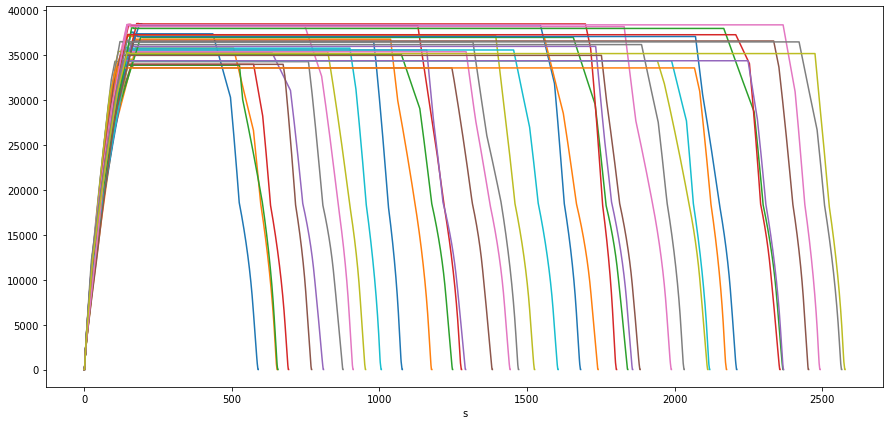

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
for (_, fp) in flight_profiles.assign(
    h=flight_profiles.h / aero.ft, s=flight_profiles.s / aero.nm
).groupby("id"):
    fp.plot(x="s", y="h", ax=ax, legend=False)

for i, range_cr in enumerate(
    range(int(wrap.cruise_range()["minimum"]), int(wrap.cruise_range()["maximum"]), 100)
):
    traj = trajs.query(f"id=={i}")
    print(
        range_cr,
        round((traj.query("fp=='CR'").s.max() - traj.query("fp=='CR'").s.min()) / 1e3),
    )

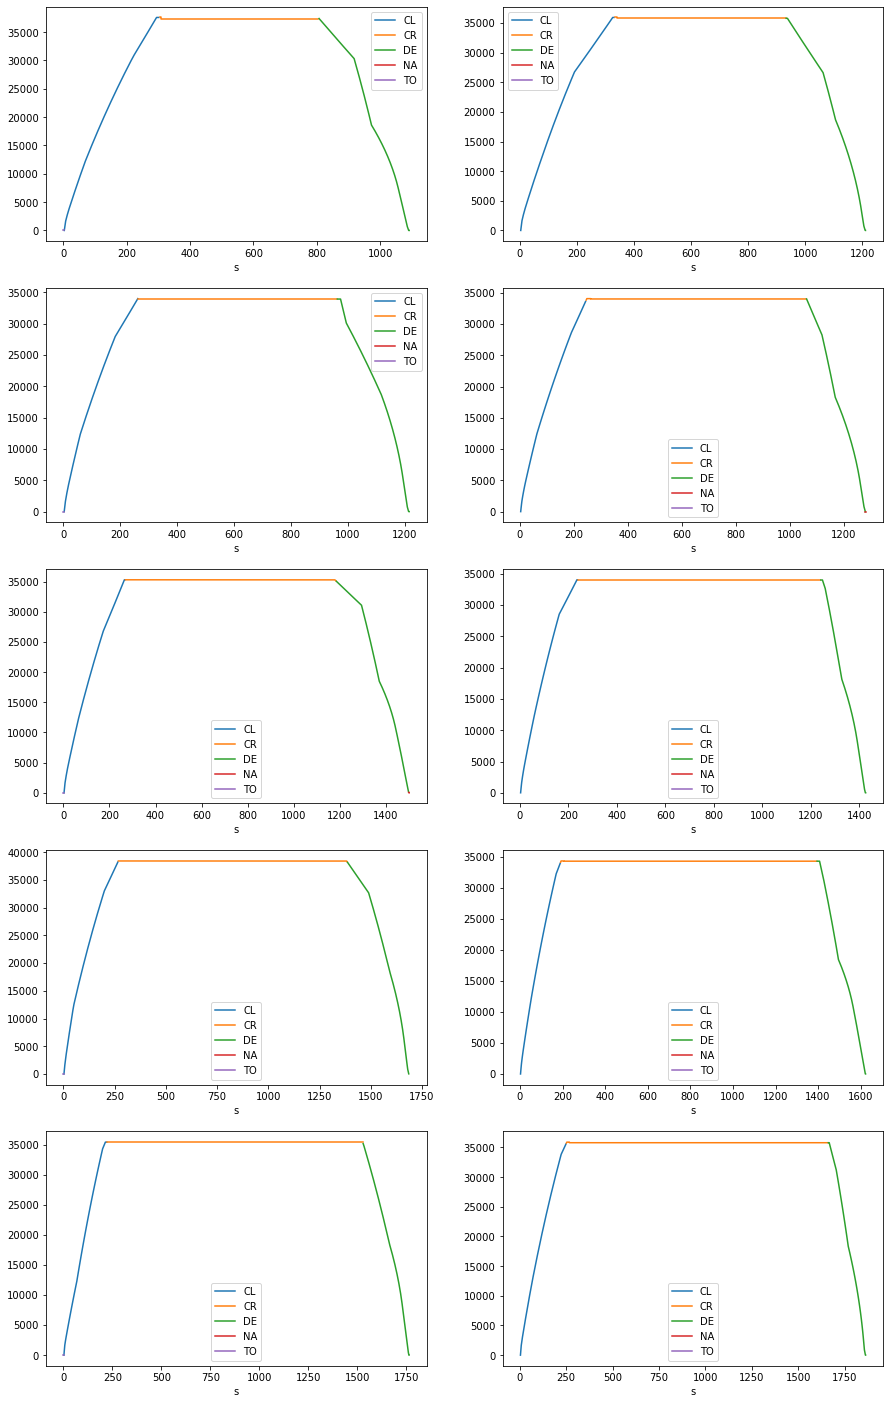

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fprof) in zip(
    axes.flat,
    flight_profiles.assign(
        h=flight_profiles.h / aero.ft, s=flight_profiles.s / 1e3
    ).groupby("id"),
):
    for fp, fprof_fp in fprof.groupby("fp"):
        fprof_fp.plot(x="s", y="h", ax=ax, label=fp)

In [9]:
prop.aircraft(ac_type)

{'aircraft': 'Airbus A320',
 'fuselage': {'length': 37.57, 'height': 4.14, 'width': 3.95},
 'wing': {'area': 124, 'span': 35.8, 'mac': 4.29, 'sweep': 25, 't/c': None},
 'flaps': {'type': 'single-slotted', 'area': 21.1, 'bf/b': 0.78},
 'limits': {'MTOW': 78000,
  'MLW': 66000,
  'OEW': 42600,
  'MFC': 24210,
  'VMO': 350,
  'MMO': 0.82,
  'ceiling': 12500},
 'cruise': {'height': 11000, 'mach': 0.78},
 'engine': {'type': 'turbofan',
  'mount': 'wing',
  'number': 2,
  'default': 'CFM56-5B4',
  'options': {'A320-111': 'CFM56-5-A1',
   'A320-211': 'CFM56-5-A1',
   'A320-212': 'CFM56-5A3',
   'A320-214': 'CFM56-5B4',
   'A320-215': 'CFM56-5B5',
   'A320-216': 'CFM56-5B6',
   'A320-231': 'V2500-A1',
   'A320-232': 'V2527-A5',
   'A320-233': 'V2527E-A5'}}}

In [10]:
thre = ThrustEstimator(ac_type=ac_type)
flight_profiles = thre(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187
...,...,...,...,...,...,...,...,...
2163,21610,0.0,4.770111e+06,59.8,0.0,38,NA,NaN
2164,21620,0.0,4.770709e+06,47.6,0.0,38,NA,NaN
2165,21630,0.0,4.771185e+06,35.4,0.0,38,NA,NaN
2166,21640,0.0,4.771539e+06,23.2,0.0,38,NA,NaN


In [11]:
me = MassEstimator(ac_type=ac_type)
fe = FuelEstimator(ac_type=ac_type, mass=me.reference_mass)
flight_profiles = fe(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr,ff
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186,2.337624
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217,2.161416
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062,2.007156
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718,1.872074
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187,1.753919
...,...,...,...,...,...,...,...,...,...
2163,21610,0.0,4.770111e+06,59.8,0.0,38,NA,NaN,NaN
2164,21620,0.0,4.770709e+06,47.6,0.0,38,NA,NaN,NaN
2165,21630,0.0,4.771185e+06,35.4,0.0,38,NA,NaN,NaN
2166,21640,0.0,4.771539e+06,23.2,0.0,38,NA,NaN,NaN


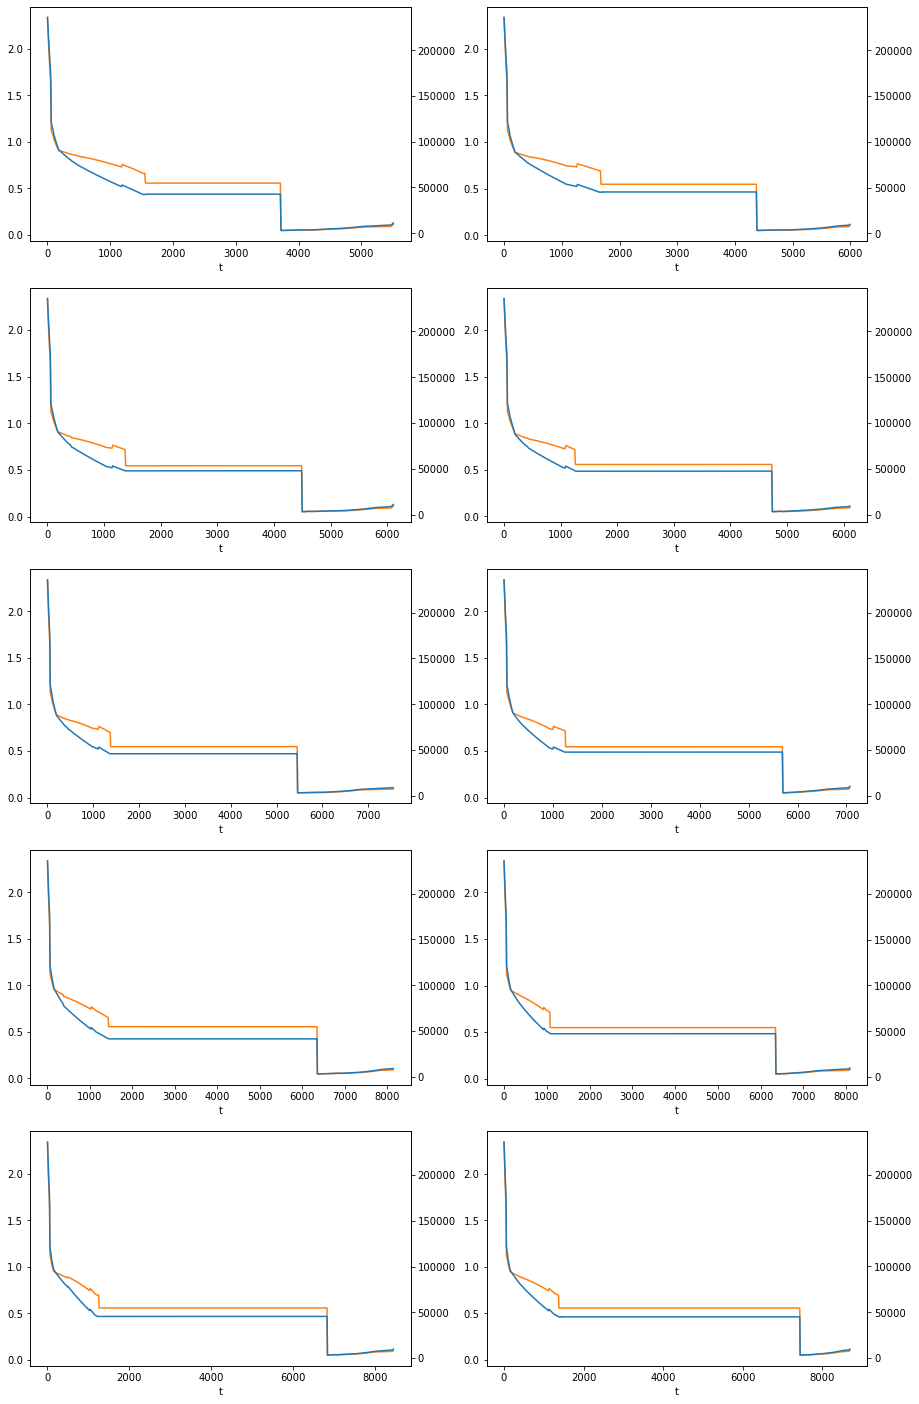

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fp) in zip(axes.flat, flight_profiles.groupby("id")):
    fp.query("ff==ff").plot(
        x="t",
        y=["thr", "ff"],
        secondary_y="thr",
        ax=ax,
        legend=False,
    )

In [13]:
flight_profiles = fe.compute_fuel_per_segment(flight_profiles)
flight_profiles

,t,h,s,v,vs,id,fp,thr,ff,fc
0,0,0.0,0.000000e+00,0.0,0.0,0,TO,235799.998186,2.337624,23.376240
1,10,0.0,0.000000e+00,19.3,0.0,0,TO,221766.340217,2.161416,44.990398
2,20,0.0,1.930000e+02,38.6,0.0,0,TO,208782.316062,2.007156,65.061956
3,30,0.0,5.790000e+02,57.9,0.0,0,TO,196847.925718,1.872074,83.782700
4,40,0.0,1.158000e+03,77.2,0.0,0,TO,185963.169187,1.753919,101.321887
...,...,...,...,...,...,...,...,...,...,...
2163,21610,0.0,4.770111e+06,59.8,0.0,38,NA,NaN,NaN,NaN
2164,21620,0.0,4.770709e+06,47.6,0.0,38,NA,NaN,NaN,NaN
2165,21630,0.0,4.771185e+06,35.4,0.0,38,NA,NaN,NaN,NaN
2166,21640,0.0,4.771539e+06,23.2,0.0,38,NA,NaN,NaN,NaN


In [19]:
fc = fe.compute_fuel_per_flight(flight_profiles)
fc

,id,fd,fc
0,0,1091.566461,2.666452
1,1,1210.488694,3.007009
2,2,1215.281009,3.020185
3,3,1280.623928,3.147130
4,4,1498.082987,3.576044
5,5,1426.082379,3.642852
6,6,1685.234924,4.111391
7,7,1622.732509,4.027536
8,8,1763.936216,4.366255
9,9,1862.773630,4.687301


<AxesSubplot:xlabel='Distance (km)', ylabel='Fuel (tonne)'>

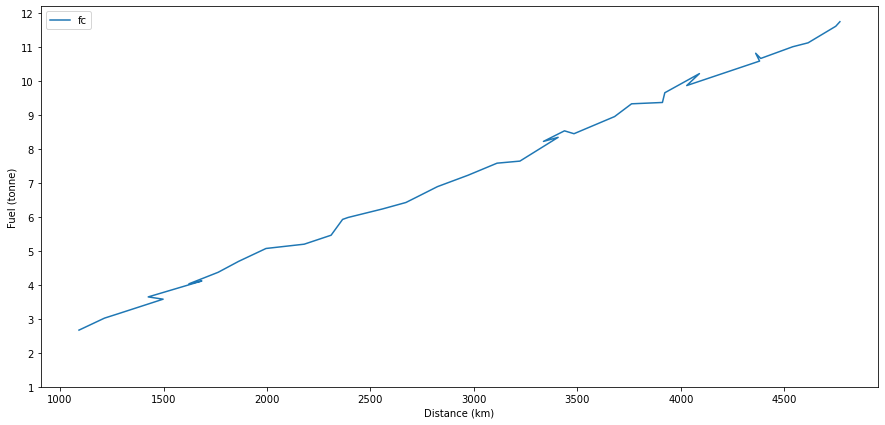

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
fc.plot(
    x="fd",
    y="fc",
    ax=ax,
    xlabel="Distance (km)",
    ylabel="Fuel (tonne)",
    yticks=range(1, 13),
)